{{title_s1_3}}

Now that we have read in and organized the stack of Sentinel-1 RTC images, let's take a look at the data.

:::{admonition} ASF data access options
The steps shown in this notebook involve downloading and extracting large volumes of data. **It is not necessary to do this to follow the rest of the content in the tutorial**. We include the demonstration for the purposes of completeness and to help users who may be in this situation.

For more information on different options for downloading data locally, see the [Introduction](../s1_intro.md#different-ways-to-use-this-tutorial).
:::


::::{tab-set}
:::{tab-item} Outline

(content.section_A)=
**[A. Read and prepare data](#a-read-and-prepare-data)**  
- {{a1_s1_nb3}}  

(content.section_B)=
**[B. Layover-shadow map](#b-layover-shadow-map)**  
- {{b1_s1_nb3}}

(content.section_C)=
**[C. Orbital direction](#c-orbital-direction)**  
- {{c1_s1_nb3}}
- {{c2_s1_nb3}}

(content.section_D)=
**[D. Duplicate time steps](#d-handling-duplicate-time-steps)**  
- {{d1_s1_nb3}}
- {{d2_s1_nb3}}
- {{d3_s1_nb3}}

(content.section_E)=
**[E. Data Visualization](#e-data-visualization)**
- {{e1_s1_nb3}}
- {{e2_s1_nb3}}
- {{e3_s1_nb3}}

:::
:::{tab-item} Learning goals  
{{concepts}}
- Spatial joins of raster and vector data.  
- Visualize raster data.  
- Use raster metadata to aid interpretation of backscatter imagery.  
- Examine data quality using provided layover-shadow maps.  
- Identify and remove duplicate time step observations.  

{{techniques}}
- Clip raster data cube using vector data with [`rioxarray.clip()`](https://corteva.github.io/rioxarray/html/examples/clip_geom.html).  
- Using `xr.groupby()` for [grouped statistics](https://docs.xarray.dev/en/stable/user-guide/groupby.html).  
- Reorganizing data with `xr.Dataset.reindex()`.  
- Visualizing multiple facets of the data using `FacetGrid`


:::
::::

:::{admonition} ASF Data Access
You can download the RTC-processed backscatter time series [here](https://zenodo.org/record/7236413#.Y1rNi37MJ-0). For more detail, see [tutorial data](../background/tutorial_data.md#sentinel-1-rtc-datasets) and the [notebook](1_read_asf_data.ipynb) on reading ASF Sentinel-1 RTC data into memory.
:::

In [1]:
#%xmode minimal
import geopandas as gpd
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import rioxarray as rio
import warnings
import xarray as xr

import s1_tools

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
cwd = pathlib.Path.cwd()
tutorial2_dir = pathlib.Path(cwd).parent

{{break}}

## A. Read and prepare data

We'll go through the steps shown in [metadata wrangling](2_wrangle_metadata.ipynb), but this time,  combined into one function from `s1_tools`. 

:::{attention} 
If you are following along on your own computer, you **must** specify `'timeseries_type'` below: 
1. Set `timeseries_type` to `'full'` or `'subset'` depending on if you are using the full time series (103 files) or the subset time series (5 files).
:::

In [3]:
timeseries_type = 'full'

In [4]:
vv_vrt_path = f"../data/{timeseries_type}_timeseries/vrt_files/s1_stack_vv.vrt"
vh_vrt_path = f"../data/{timeseries_type}_timeseries/vrt_files/s1_stack_vh.vrt"
ls_vrt_path = f"../data/{timeseries_type}_timeseries/vrt_files/s1_stack_ls_map.vrt"

In [5]:
asf_data_cube = s1_tools.metadata_processor(
    vv_path=vv_vrt_path, 
    vh_path=vh_vrt_path, 
    ls_path=ls_vrt_path,
    timeseries_type = timeseries_type
)

In [7]:
asf_data_cube

<xarray.Dataset> Size: 289GB
Dimensions:        (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x              (x) float64 140kB 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y              (y) float64 107kB 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref    int64 8B 0
    ls             (acq_date, y, x) float32 96GB dask.array<chunksize=(11, 1536, 1536), meta=np.ndarray>
  * acq_date       (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 202...
    product_id     (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '1380' 'E5B6'
    data_take_ID   (acq_date) <U6 2kB '047321' '047463' ... '052C00' '052C00'
    abs_orbit_num  (acq_date) <U6 2kB '037709' '037745' ... '043309' '043309'
Data variables:
    vh             (acq_date, y, x) float32 96GB dask.array<chunksize=(11, 1536, 1536), meta=np.ndarray>
    vv             (acq_date, y, x) float32 96GB dask.array<chunksize=(11, 1536, 1536), meta=np.ndarray>
Attributes: (12/13)
    sensor:                            S1A
    output_unit:                       p
    primary_polarization:              V
    output_type:                       g
    notfiltered_or_filtered:           n
    processing_software:               G
    ...                                ...
    deadreckoning_or_demmatch:         d
    area_or_clipped:                   e
    terrain_correction_pixel_spacing:  RTC30
    polarization_type:                 D
    beam_mode:                         IW
    orbit_type:                        P

### {{a1_s1_nb3}}

Until now, we've kept the full spatial extent of the dataset. This hasn't been a problem because all of our operations have been lazy. Now, we'd like to visualize the dataset in ways that require eager instead of lazy computation. We subset the data cube to a smaller area to focus on a location interest to make computation more less computationally-intensive.

Later notebooks use a different Sentinel-1 RTC dataset that is accessed for a smaller area of interest. Clip the current data cube to that spatial footprint:

In [8]:
# Read vector data
pc_aoi = gpd.read_file(
    "https://github.com/e-marshall/sentinel1_rtc/raw/main/hma_rtc_aoi.geojson"
)

Visualize location

In [9]:
pc_aoi.explore()

Check the CRS and ensure it matches that of the raster data cube:

In [9]:
assert asf_data_cube.rio.crs == pc_aoi.crs, (
    f"Expected: {asf_data_cube.rio.crs}, received: {pc_aoi.crs}"
)

Clip the raster data cube by the extent of the vector:

In [10]:
clipped_cube = asf_data_cube.rio.clip(pc_aoi.geometry, pc_aoi.crs)
clipped_cube

<xarray.Dataset> Size: 142MB
Dimensions:        (x: 290, y: 396, acq_date: 103)
Coordinates:
  * x              (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y              (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    ls             (acq_date, y, x) float32 47MB dask.array<chunksize=(11, 396, 290), meta=np.ndarray>
  * acq_date       (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 202...
    product_id     (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '1380' 'E5B6'
    data_take_ID   (acq_date) <U6 2kB '047321' '047463' ... '052C00' '052C00'
    abs_orbit_num  (acq_date) <U6 2kB '037709' '037745' ... '043309' '043309'
    spatial_ref    int64 8B 0
Data variables:
    vh             (acq_date, y, x) float32 47MB dask.array<chunksize=(11, 396, 290), meta=np.ndarray>
    vv             (acq_date, y, x) float32 47MB dask.array<chunksize=(11, 396, 290), meta=np.ndarray>
Attributes: (12/13)
    sensor:                            S1A
    output_unit:                       p
    primary_polarization:              V
    output_type:                       g
    notfiltered_or_filtered:           n
    processing_software:               G
    ...                                ...
    deadreckoning_or_demmatch:         d
    area_or_clipped:                   e
    terrain_correction_pixel_spacing:  RTC30
    polarization_type:                 D
    beam_mode:                         IW
    orbit_type:                        P

Use [`xr.Dataset.persist()`](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.persist.html); this method is an integration of Dask with Xarray. It will trigger the background computation of the operations we've so far executed lazily. Persist is similar to compute but it keeps the underlying data as dask-backed arrays instead of converting them to NumPy arrays.

In [11]:
clipped_cube = clipped_cube.persist()

In [12]:
clipped_cube.compute()

<xarray.Dataset> Size: 142MB
Dimensions:        (x: 290, y: 396, acq_date: 103)
Coordinates:
  * x              (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y              (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    ls             (acq_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
  * acq_date       (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 202...
    product_id     (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '1380' 'E5B6'
    data_take_ID   (acq_date) <U6 2kB '047321' '047463' ... '052C00' '052C00'
    abs_orbit_num  (acq_date) <U6 2kB '037709' '037745' ... '043309' '043309'
    spatial_ref    int64 8B 0
Data variables:
    vh             (acq_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    vv             (acq_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
Attributes: (12/13)
    sensor:                            S1A
    output_unit:                       p
    primary_polarization:              V
    output_type:                       g
    notfiltered_or_filtered:           n
    processing_software:               G
    ...                                ...
    deadreckoning_or_demmatch:         d
    area_or_clipped:                   e
    terrain_correction_pixel_spacing:  RTC30
    polarization_type:                 D
    beam_mode:                         IW
    orbit_type:                        P

Great, we've gone from an object where each 3-d variable is ~ 90 GB to one where each 3-d variable is ~45 MB, this will be much easier to work with.

## B. Layover-shadow map


As discussed in previous notebooks, every Sentinel-1 scene comes with an associated layover shadow mask GeoTIFF file. This map describes the presence of layover, shadow and slope angle conditions that can impact backscatter values in a scene, which is especially important to consider in high-relief settings with more potential for geometric distortions

The following information is copied from the README file that accompanies each scene: 

```{**Layover-shadow mask**}

The layover/shadow mask indicates which pixels in the RTC image have been affected by layover and shadow. This layer is tagged with _ls_map.tif

The pixel values are generated by adding the following values together to indicate which layover and shadow effects are impacting each pixel:
0.  Pixel not tested for layover or shadow
1.  Pixel tested for layover or shadow
2.  Pixel has a look angle less than the slope angle
4.  Pixel is in an area affected by layover
8.  Pixel has a look angle less than the opposite of the slope angle
16. Pixel is in an area affected by shadow

There are 17 possible different pixel values, indicating the layover, shadow, and slope conditions present added together for any given pixel._

The values in each cell can range from 0 to 31:
0.  Not tested for layover or shadow
1.  Not affected by either layover or shadow
3.  Look angle < slope angle
5.  Affected by layover
7.  Affected by layover; look angle < slope angle
9.  Look angle < opposite slope angle
11. Look angle < slope and opposite slope angle
13. Affected by layover; look angle < opposite slope angle
15. Affected by layover; look angle < slope and opposite slope angle
17. Affected by shadow
19. Affected by shadow; look angle < slope angle
21. Affected by layover and shadow
23. Affected by layover and shadow; look angle < slope angle
25. Affected by shadow; look angle < opposite slope angle
27. Affected by shadow; look angle < slope and opposite slope angle
29. Affected by shadow and layover; look angle < opposite slope angle
31. Affected by shadow and layover; look angle < slope and opposite slope angle

```

The ASF RTC image [product guide](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/) has detailed descriptions of how the data is processed and what is included in the processed dataset.

The `layover-shadow` variable provides categorical information so we'll use a qualitative colormap to visualize it.

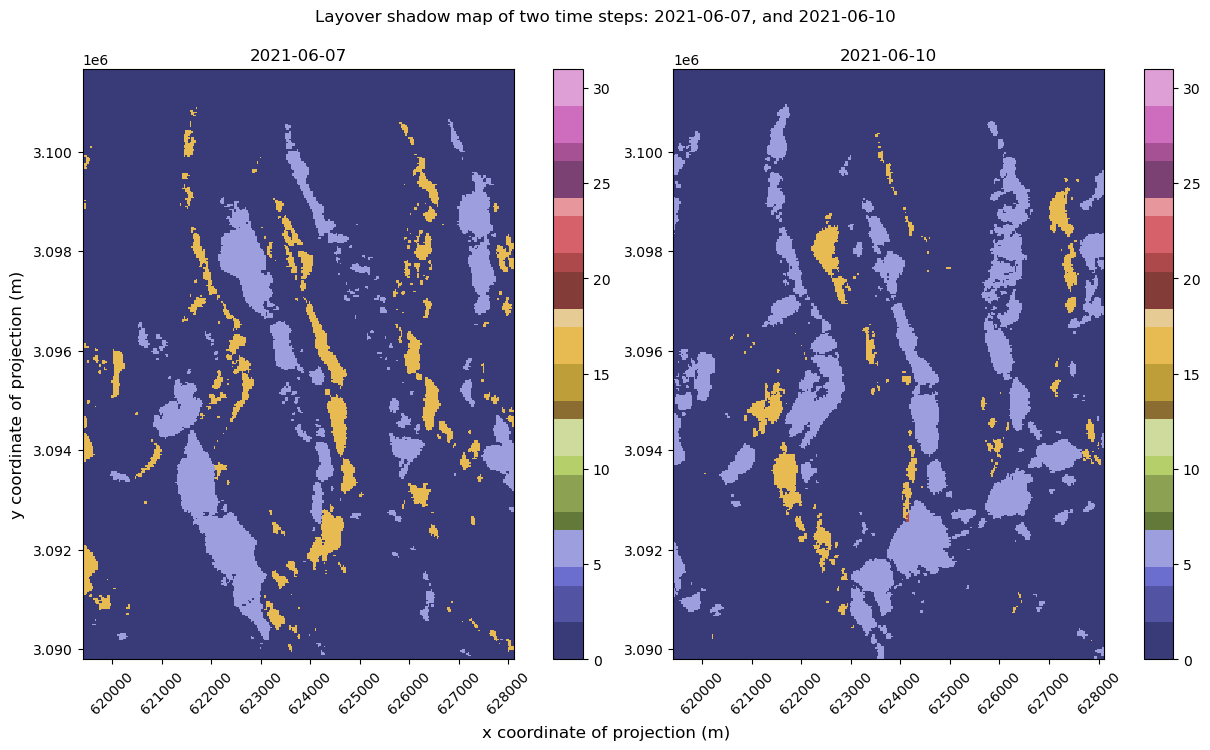

In [15]:
cat_cmap = plt.get_cmap('tab20b', lut=32)
time_step1 = '2021-06-07' #10
time_step2 = '2021-06-10' #11

if timeseries_type == 'subset':
    time_step1 = 1
    time_step2 = 3

fig, axs = plt.subplots(ncols=2, figsize=(12,7), layout='constrained')

clipped_cube.sel(acq_date=time_step1).ls.plot(ax=axs[0], 
                                       cmap=cat_cmap,
                                       cbar_kwargs=({'label':None}),
                                       vmin=0, vmax=31)

clipped_cube.sel(acq_date=time_step2).ls.plot(ax=axs[1], 
                                       cmap=cat_cmap,
                                       cbar_kwargs=({'label':None}),
                                       vmin=0, vmax=31)

fig.suptitle(
    f"Layover shadow map of two time steps: {time_step1}, and {time_step2}",
    y=1.05
)
for i in range(len(axs)):
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='x', labelrotation=45);

axs[0].set_title(time_step1)
axs[1].set_title(time_step2)
fig.supylabel('y coordinate of projection (m)')
fig.supxlabel('x coordinate of projection (m)');


It looks like there are areas affected by different types of distortion on different dates. For example, in the lower left quadrant, there is a region that is blue (5 - affected by layover) on 6/7/2021 but much of that area appear yellow (16 - affected by radar shadow) on 6/10/2021. This pattern is present throughout much of the scene with portions of area that are affected by layover in one acquisition in shadow in the next acquisition. This is not due to any real changes on the ground that occurred between the two acquisitions, rather it is the different viewing geometries of the orbital passes: one of the above scenes was collected during an ascending pass of the satellite and one during a descending pass. Since Setinel-1 is always looking to the same side, ascending and descending passes will view the same area on the ground from opposing perspectives.

### {{b1_s1_nb3}}
We can use Xarray's integration with [hvplot](https://hvplot.holoviz.org/) (a library within the [holoviz](https://hvplot.holoviz.org/index.html) ecosystem) to look at the time series of layover-shadow maps interactively. Read more about interactive plots with Xarray and hvplot [here](https://tutorial.xarray.dev/intermediate/hvplot.html).

To do this, we need to demote `'ls'` from a coordinate variable to a data variable because of how `hvplot.xarray` expects the data to be structured. We can do this with [`xr.reset_coords()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.reset_coords.html#xarray.Dataset.reset_coords). First, recreate the above layover-shadow plot using hvplot:

In [16]:
ls_var = clipped_cube.reset_coords('ls')

(ls_var.ls.sel(acq_date=time_step1).squeeze().hvplot(cmap='tab20b', 
        width=400, height=350,
        clim=(0,32), #specify the limits of the colorbar to match original
        title=f"Acq date: {time_step1}") 
        + 
ls_var.ls.sel(acq_date=time_step2).squeeze().hvplot(cmap='tab20b', 
        width=400, height=350,
        clim=(0,32),
        title=f"Acq date: {time_step2}") 
)

:Layout
   .Image.I  :Image   [x,y]   (ls)
   .Image.II :Image   [x,y]   (ls)

(content:orbital_dir_section)=
## C. Orbital direction

Sentinel-1 is a right-looking sensor and it images areas on Earth’s surface in orbits when it is moving N-S (a descending orbit) and S-N (an ascending orbit). For a given scene, it images the same footprint on both passes but from different directions. The data coverage map below illustrates these directional passes with ascending passes moving from southeast to northwest and descending passes moving from northeast to southwest , it can be found online [here](https://asf.alaska.edu/daac/sentinel-1-acquisition-maps/).

```{image} ../imgs/slc_coverage_asf.png
:align center
```
ASF Sentinel-1 Cumulative coverage map.

In areas of high-relief topography such as the area we’re observing, there can be strong terrain distortion effects such as layover and shadow. These are some of the distortions that RTC processing corrects, but sometimes it is not possible to reliably extract backscatter for correction in the presence of strong distortions. The above image shows the layover-shadow map for an ascending and a descending image side-by-side, which is why different areas are affected by layover (5) and shadow (17) in each.

Thanks to all the setup work we did in the previous notebook, we can quickly confirm that all of the observations were taken at two times of day, corresponding to ascending and descending passes of the satellite, and that the time steps shown above were taken at different times of day.

:::{note}
The acquisition time of Sentinel-1 images is not in local time.
:::

In [17]:
print(
    f"Hour of day of acquisition {time_step1}: ",
    clipped_cube.sel(acq_date=time_step1).acq_date.dt.hour.data,
)
print(
    f"Hour of day of acquisition {time_step2}: ",
    clipped_cube.sel(acq_date=time_step2).acq_date.dt.hour.data,
)
clipped_cube.acq_date.dt.hour

Hour of day of acquisition 2021-06-07:  [12]
Hour of day of acquisition 2021-06-10:  [0]


<xarray.DataArray 'hour' (acq_date: 103)> Size: 824B
array([12,  0, 12, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,
       12,  0, 12, 12, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12,
       12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0,
       12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,
        0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12,
       12,  0, 12, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12, 12, 12, 12,
       12])
Coordinates:
  * acq_date       (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 202...
    product_id     (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '1380' 'E5B6'
    data_take_ID   (acq_date) <U6 2kB '047321' '047463' ... '052C00' '052C00'
    abs_orbit_num  (acq_date) <U6 2kB '037709' '037745' ... '043309' '043309'
    spatial_ref    int64 8B 0

### {{c1_s1_nb3}}

In this example, it was relatively simple to determine one pass from another, but it is less straightforward to know if a pass is ascending or descending. The timing of these passes depends on the location on earth of the image. 

In the location covered by this dataset, ascending passes correspond to an acquisition time roughly 0:00 UTC and descending passes correspond to approximately 12:00 UTC. 

### {{c2_s1_nb3}}
This is another example of time-varying metadata, so it should be stored as a coordinate variable. Use [`xr.where()`](https://docs.xarray.dev/en/stable/generated/xarray.where.html) to assign the correct orbital direction value depending on an observation's acquisition time and then assign it as a coordinate variable to the clipped raster data cube.

In [18]:
clipped_cube.coords["orbital_dir"] = (
    "acq_date",
    xr.where(clipped_cube.acq_date.dt.hour.data == 0, "asc", "desc"),
)

## D. Duplicate time steps

If we take a closer look at the ASF dataset, we can see that there are a few scenes from identical acquisitions (this is apparent in `acq_date` and more specifically in `product_id`). Let's examine these and see what's going on. 

:::{note}
This section **will not work** if you're using the subset timeseries.
:::

### {{d1_s1_nb3}}

First we'll extract the `data_take_ID` from the Sentinel-1 granule ID: 

In [19]:
clipped_cube.data_take_ID.data

array(['047321', '047463', '047676', '047898', '047898', '0479A9',
       '047BBD', '047DE5', '047EF4', '0480FD', '048318', '04841E',
       '04862F', '04884C', '04895A', '048B6C', '048D87', '048D87',
       '048E99', '0490AD', '0492D4', '0492D4', '0492D4', '0493DB',
       '0495EC', '04980F', '04991E', '049B1F', '049D70', '049EAC',
       '04A0FF', '04A383', '04A4B9', '04A6FC', '04A972', '04AAB3',
       '04AD0D', '04AF85', '04B0C4', '04B2FB', '04B566', '04B6AB',
       '04B8FF', '04BB88', '04BCB8', '04BF12', '04C195', '04C2D6',
       '04C52E', '04C7A8', '04C8E9', '04CB46', '04CDC8', '04CEFF',
       '04D14F', '04D3CC', '04D50E', '04D761', '04D9E8', '04DB21',
       '04DD71', '04DFDD', '04E110', '04E340', '04E5AB', '04E6D7',
       '04E931', '04EB9B', '04ECCD', '04EEE8', '04F156', '04F294',
       '04F4D6', '04F754', '04F88B', '04FAF5', '04FD6F', '04FEB2',
       '050108', '050376', '0504AF', '0506F7', '050962', '050AA2',
       '050CE5', '050F59', '051096', '0512D7', '05154A', '0515

Let's look at the number of unique elements using [`np.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html).

In [20]:
data_take_ids_ls = clipped_cube.data_take_ID.data.tolist()
data_take_id_set = np.unique(clipped_cube.data_take_ID)
len(data_take_id_set)

96

Interesting - it looks likethere are only 96 unique elements. Let's figure out which are duplicates:

In [21]:
def duplicate(input_ls):
    return list(set([x for x in input_ls if input_ls.count(x) > 1]))

duplicate_ls = duplicate(data_take_ids_ls)
duplicate_ls

['047898', '0492D4', '048D87', '05154A', '052C00']

These are the data take IDs that are duplicated in the dataset. We now want to subset the xarray object to only include these data take IDs: 

In [22]:
asf_duplicate_cond = clipped_cube.data_take_ID.isin(duplicate_ls)
asf_duplicate_cond

<xarray.DataArray 'data_take_ID' (acq_date: 103)> Size: 103B
array([False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True])
Coordinates:
  * acq_date       (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 202...
    product_id     (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '1380' 'E5B6'
    data_take_ID   (acq_date) <U6 2kB '047321' '047463' ... '052C00' '052C00'
    abs_orbit_num  (acq_date) <U6 2kB '037709' '037745' ... '043309' '043309'
    spatial_ref    int64 8B 0
    orbital_dir    (acq_date) <U4 2kB 'desc' 'asc' 'desc' ... 'desc' 'desc'

In [23]:
duplicates_cube = clipped_cube.where(asf_duplicate_cond == True, drop=True)
duplicates_cube

<xarray.Dataset> Size: 17MB
Dimensions:        (acq_date: 12, y: 396, x: 290)
Coordinates:
  * x              (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y              (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    ls             (acq_date, y, x) float32 6MB dask.array<chunksize=(10, 396, 290), meta=np.ndarray>
  * acq_date       (acq_date) datetime64[ns] 96B 2021-05-14T12:13:49 ... 2022...
    product_id     (acq_date) <U4 192B '971C' 'FA4F' '0031' ... '1380' 'E5B6'
    data_take_ID   (acq_date) <U6 288B '047898' '047898' ... '052C00' '052C00'
    abs_orbit_num  (acq_date) <U6 288B '037884' '037884' ... '043309' '043309'
    spatial_ref    int64 8B 0
    orbital_dir    (acq_date) <U4 192B 'desc' 'desc' 'desc' ... 'desc' 'desc'
Data variables:
    vh             (acq_date, y, x) float32 6MB dask.array<chunksize=(10, 396, 290), meta=np.ndarray>
    vv             (acq_date, y, x) float32 6MB dask.array<chunksize=(10, 396, 290), meta=np.ndarray>
Attributes: (12/13)
    unmasked_or_watermasked:           u
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    sensor:                            S1A
    ...                                ...
    processing_software:               G
    terrain_correction_pixel_spacing:  RTC30
    orbit_type:                        P
    output_type:                       g
    output_unit:                       p
    primary_polarization:              V

### {{d2_s1_nb3}}

Great, now we have a 12-time step Xarray object that contains only the duplicate data takes. Let's see what it looks like. We can use `xr.FacetGrid` objects to plot all of the arrays at once.

Before we make a FacetGrid plot, we need to make a change to the dataset. FacetGrid takes a column and expands the levels of the provided dimension into individual sub-plots (a small multiples plot). We're looking at the duplicate time steps, meaning the elements of the `acq_date` dimension are non-unique. FacetGrid expects unique values along the specified coordinate array. If we were to directly call: 
```python
fg = duplicates_cube.vv.plot(col="acq_date", col_wrap=4)
``` 
We would receive the following error: 
```
ValueError: Coordinates used for faceting cannot contain repeated (nonunique) values.
```


Renaming the dimensions of `duplicates_cube` with [`xr.rename_dims()`](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.rename_dims.html) demotes the `acq_date` coordinate array to non-dimensional coordinate and replaces it with `step` an array of integers. Because these are unique, we can make a FaceGrid plot with the `step` dimension.

In [24]:
duplicates_cube.rename_dims({'acq_date':'step'})

<xarray.Dataset> Size: 17MB
Dimensions:        (step: 12, y: 396, x: 290)
Coordinates:
  * x              (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y              (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    ls             (step, y, x) float32 6MB dask.array<chunksize=(10, 396, 290), meta=np.ndarray>
  * acq_date       (step) datetime64[ns] 96B 2021-05-14T12:13:49 ... 2022-05-...
    product_id     (step) <U4 192B '971C' 'FA4F' '0031' ... 'CA1B' '1380' 'E5B6'
    data_take_ID   (step) <U6 288B '047898' '047898' ... '052C00' '052C00'
    abs_orbit_num  (step) <U6 288B '037884' '037884' ... '043309' '043309'
    spatial_ref    int64 8B 0
    orbital_dir    (step) <U4 192B 'desc' 'desc' 'desc' ... 'desc' 'desc' 'desc'
Dimensions without coordinates: step
Data variables:
    vh             (step, y, x) float32 6MB dask.array<chunksize=(10, 396, 290), meta=np.ndarray>
    vv             (step, y, x) float32 6MB dask.array<chunksize=(10, 396, 290), meta=np.ndarray>
Attributes: (12/13)
    unmasked_or_watermasked:           u
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    sensor:                            S1A
    ...                                ...
    processing_software:               G
    terrain_correction_pixel_spacing:  RTC30
    orbit_type:                        P
    output_type:                       g
    output_unit:                       p
    primary_polarization:              V

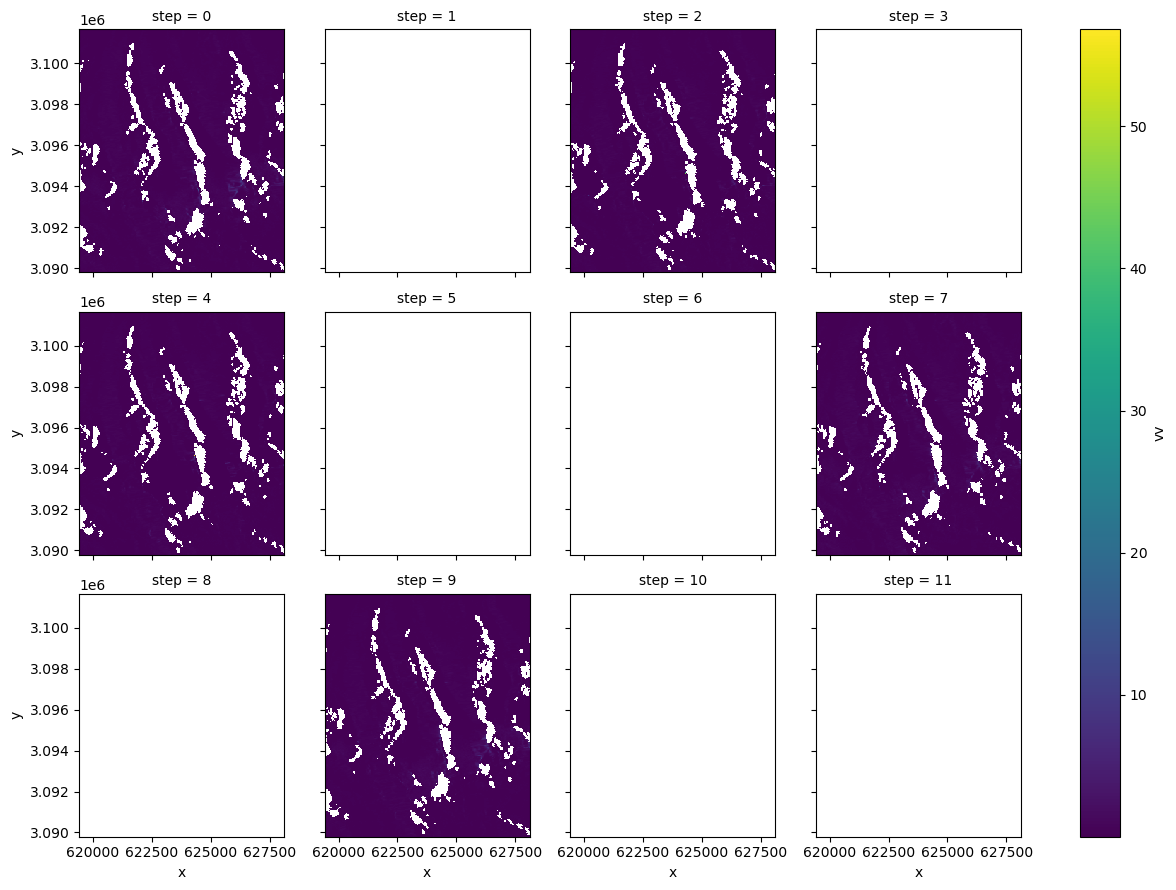

In [25]:
fg = duplicates_cube.rename_dims({"acq_date": "step"}).vv.plot(col="step", col_wrap=4)

Interesting, it looks like there's only really data for the 0, 2, 4, 7 and 9 elements of the list of duplicates. It could be that the processing of these files was interrupted and then restarted, producing extra empty arrays.

### {{d3_s1_nb3}}

To drop these arrays, extract the product ID (the only variable that is unique among the duplicates) of each array we'd like to remove.

In [26]:
drop_ls = [1, 3, 5, 6, 8, 10, 11]

We can use xarray's `.isel()` method, `.xr.DataArray.isin()`, `xr.Dataset.where()`, and list comprehension to efficiently subset the time steps we want to keep: 

In [27]:
drop_product_id_ls = duplicates_cube.isel(acq_date=drop_ls).product_id.data
drop_product_id_ls

array(['FA4F', '65E0', 'E113', '24B8', '57F2', '1380', 'E5B6'],
      dtype='<U4')

Using this list, we want to drop all of the elements of `clipped_cube` where product Id is one of the values in the list.

In [28]:
duplicate_cond = ~clipped_cube.product_id.isin(drop_product_id_ls)
clipped_cube = clipped_cube.where(duplicate_cond == True, drop=True)
clipped_cube

<xarray.Dataset> Size: 132MB
Dimensions:        (acq_date: 96, y: 396, x: 290)
Coordinates:
  * x              (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y              (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    ls             (acq_date, y, x) float32 44MB dask.array<chunksize=(10, 396, 290), meta=np.ndarray>
  * acq_date       (acq_date) datetime64[ns] 768B 2021-05-02T12:14:14 ... 202...
    product_id     (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '7418' 'CA1B'
    data_take_ID   (acq_date) <U6 2kB '047321' '047463' ... '0529DD' '052C00'
    abs_orbit_num  (acq_date) <U6 2kB '037709' '037745' ... '043236' '043309'
    spatial_ref    int64 8B 0
    orbital_dir    (acq_date) <U4 2kB 'desc' 'asc' 'desc' ... 'desc' 'desc'
Data variables:
    vh             (acq_date, y, x) float32 44MB dask.array<chunksize=(10, 396, 290), meta=np.ndarray>
    vv             (acq_date, y, x) float32 44MB dask.array<chunksize=(10, 396, 290), meta=np.ndarray>
Attributes: (12/13)
    unmasked_or_watermasked:           u
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    sensor:                            S1A
    ...                                ...
    processing_software:               G
    terrain_correction_pixel_spacing:  RTC30
    orbit_type:                        P
    output_type:                       g
    output_unit:                       p
    primary_polarization:              V

## E. Examining coverage over time series

The previous section showed that there are some scenes in the time series with no data over the area of interest. Let's see if there are any data coverage characteristics we should examine more closely in the dataset. There are a number of ways to do this but approach we'll use here is to first calculate the percentage of pixels containing data relative to the entire footprint for each time step:

In [30]:
max_pixels = clipped_cube.ls.notnull().any('acq_date').sum(['x','y'])
valid_pixels = clipped_cube.ls.count(dim=['x','y'])
clipped_cube['cov'] = (valid_pixels / max_pixels)*100

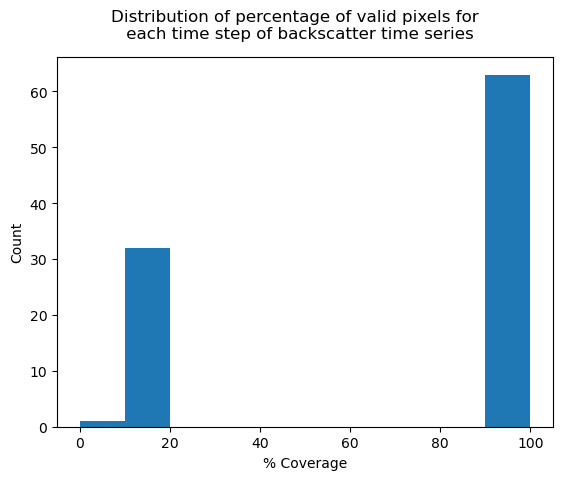

In [32]:
fig, ax = plt.subplots()
fig.suptitle('Distribution of percentage of valid pixels for \n each time step of backscatter time series')
clipped_cube['cov'].plot.hist(ax=ax)
ax.set_xlabel('% Coverage')
ax.set_title(None)
ax.set_ylabel('Count');

In addition to the empty duplicate time steps we removed above, there are many other time steps with minimal coverage. This is likely becuase the original time series contians scenes from multiple satellite footprints, and some may have minimal coverage over the area of interest that was used to clip the time series. To check this, we can again use Xarray's interactive visualization tools, this time to create an animation that loops through the time series. We'll get a bunch of warnings and errors if we try to make an animation of a time series with empty time steps, so we'll first remove any empty time steps (likely also caused by satellite footprints in the original time series that don't cover the smaller area of interest) and look just at scenes with some data:

:::{admonition} Masking with dask-backed arrays
If we tried to use `xr.Dataset.where()` to mask and drop time steps where coverage is zero right now, we would get the following error: 
```
KeyError: 'Indexing with a boolean dask array is not allowed. This will result in a dask array of unknown shape. Such arrays are unsupported by Xarray.Please compute the indexer first using .compute()'
```
Because we only called `.persist()` earlier, the arrays of the data variables are still Dask arrays instead of NumPy arrays. Calling `compute()` or `.load()` will resolve this issue and allow us to drop empty time steps: 


In [33]:
clipped_cube.load()

<xarray.Dataset> Size: 132MB
Dimensions:        (acq_date: 96, y: 396, x: 290)
Coordinates:
  * x              (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y              (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    ls             (acq_date, y, x) float32 44MB nan nan nan nan ... 1.0 1.0 1.0
  * acq_date       (acq_date) datetime64[ns] 768B 2021-05-02T12:14:14 ... 202...
    product_id     (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '7418' 'CA1B'
    data_take_ID   (acq_date) <U6 2kB '047321' '047463' ... '0529DD' '052C00'
    abs_orbit_num  (acq_date) <U6 2kB '037709' '037745' ... '043236' '043309'
    spatial_ref    int64 8B 0
    orbital_dir    (acq_date) <U4 2kB 'desc' 'asc' 'desc' ... 'desc' 'desc'
Data variables:
    vh             (acq_date, y, x) float32 44MB nan nan nan ... 0.0375 0.03803
    vv             (acq_date, y, x) float32 44MB nan nan nan ... 0.3252 0.3992
    cov            (acq_date) float64 768B 0.0 100.0 14.06 ... 100.0 13.96 100.0
Attributes: (12/13)
    unmasked_or_watermasked:           u
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    sensor:                            S1A
    ...                                ...
    processing_software:               G
    terrain_correction_pixel_spacing:  RTC30
    orbit_type:                        P
    output_type:                       g
    output_unit:                       p
    primary_polarization:              V

In [34]:
clipped_cube = clipped_cube.where(clipped_cube.cov > 0., drop=True)

Now that we've dropped the empty time steps, we can use hvplot to make an animation showing the layover-shadow map for each element in the time series:

In [35]:
clipped_cube.reset_coords('ls').ls.hvplot(groupby='acq_date',
             clim=(0,32),
             cmap='tab20b',
             widget_type="scrubber",
            widget_location="bottom",)

BokehModel(combine_events=True, render_bundle={'docs_json': {'6e322f85-e012-44ff-a712-62ed76ec4033': {'version…

From the animation we can see that it looks like there are two main viewing geometries in the time series, and that one  of them covers the area of interest well while the other does not. Let's remove the time steps where coverage is less than 100. We won't need the `'cov'` variable anymore so we can drop it as well:

In [36]:
clipped_cube = clipped_cube.where(clipped_cube.cov == 100, drop=True).drop_vars('cov')

In [37]:
clipped_cube

<xarray.Dataset> Size: 87MB
Dimensions:        (acq_date: 63, y: 396, x: 290)
Coordinates:
  * x              (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y              (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    ls             (acq_date, y, x) float32 29MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
  * acq_date       (acq_date) datetime64[ns] 504B 2021-05-05T00:03:07 ... 202...
    product_id     (acq_date) <U4 1kB '54B1' '971C' 'D35A' ... '33F5' 'CA1B'
    data_take_ID   (acq_date) <U6 2kB '047463' '047898' ... '0526C4' '052C00'
    abs_orbit_num  (acq_date) <U6 2kB '037745' '037884' ... '043134' '043309'
    spatial_ref    int64 8B 0
    orbital_dir    (acq_date) <U4 1kB 'asc' 'desc' 'asc' ... 'asc' 'desc' 'desc'
Data variables:
    vh             (acq_date, y, x) float32 29MB 0.01556 0.01491 ... 0.03803
    vv             (acq_date, y, x) float32 29MB 0.1062 0.1219 ... 0.3252 0.3992
Attributes: (12/13)
    unmasked_or_watermasked:           u
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    sensor:                            S1A
    ...                                ...
    processing_software:               G
    terrain_correction_pixel_spacing:  RTC30
    orbit_type:                        P
    output_type:                       g
    output_unit:                       p
    primary_polarization:              V

In [38]:
clipped_cube.reset_coords('ls').ls.hvplot(groupby='acq_date',
             clim=(0,32),
             cmap='tab20b',
             widget_type="scrubber",
            widget_location="bottom",)

BokehModel(combine_events=True, render_bundle={'docs_json': {'a6886d66-bb58-4c5c-97a8-58af1485d857': {'version…

## F. Data visualization

Now that we've visualized and taken a closer look at metadata such as the layover-shadow map and orbital direction, let's focus on backscatter variability. In the plotting calls in this notebook, we'll use a function in `s1_tools.py` that applies a logarithmic transformation to the data. This makes it easier to visualize variability, however, it is important to apply it as a last step before visualizing and to not perform statistical calculations on the log-transformed data.

:::{admonition} A note on visualizing SAR data
The measurements that we're provided in the RTC dataset are in intensity, or power, scale. Often, to visualize SAR backscatter, the data is converted from power to normalized radar cross section (the backscatter coefficient). This is in decibel (dB) units, meaning a log transform has been applied. This transformation makes it easier to visualize variability but it is important not to calculate summary statistics on log-transformed data as it will be distorted. You can read more about these concepts [here](https://hyp3-docs.asf.alaska.edu/guides/introduction_to_sar/#sar-scale).
:::

### {{e1_s1_nb3}}

This section examines two approaches of plotting VV and VH backscatter side by side that can have important consequences when visualizing and interpreting data. 

Currently, VV and VH are two data variables of the data cube that both exist along x,y and time dimensions. If we plot them both as individual subplots, we'll see two subplots, each with their own colormap. If you look closely, you can see that the colormaps are not on the same scale. We need to be careful when interpreting these images and comparing backscatter in the VV and VH images in this situation

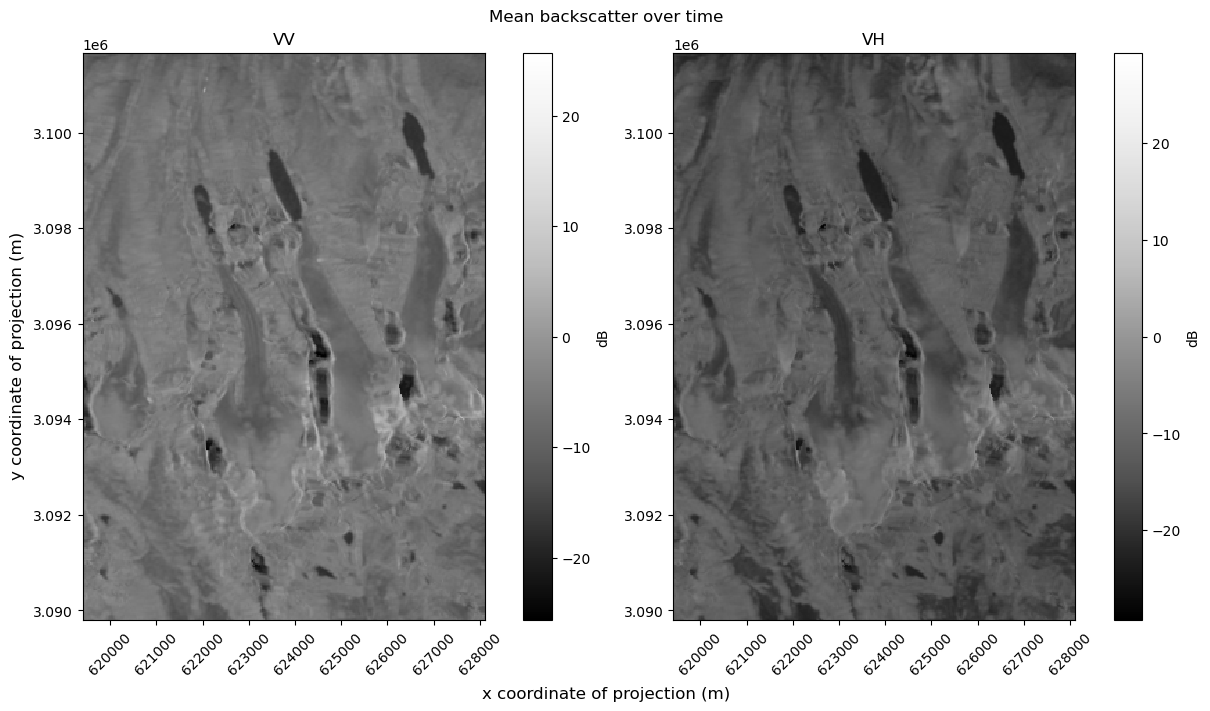

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(12,7),layout='constrained')

s1_tools.power_to_db(clipped_cube['vv'].mean(dim='acq_date')).plot(ax=ax[0],
                                                                   cmap=plt.cm.Greys_r, 
                                                                   cbar_kwargs=({'label':'dB'}))
s1_tools.power_to_db(clipped_cube['vh'].mean(dim='acq_date')).plot(ax=ax[1],
                                                                   cmap=plt.cm.Greys_r,
                                                                   cbar_kwargs=({'label':'dB'}))

for i in range(len(ax)):
    ax[i].set_ylabel(None)
    ax[i].set_xlabel(None)
    ax[i].tick_params(axis="x", labelrotation=45)
fig.suptitle('Mean backscatter over time')
ax[0].set_title('VV')
ax[1].set_title('VH')
fig.supylabel('y coordinate of projection (m)')
fig.supxlabel('x coordinate of projection (m)');

There are two ways to fix this: 


#### Specify min and max values in plotting call


We could normalize the backscatter ranges for both variables by manually specifying a minimum and a maximum across both. 

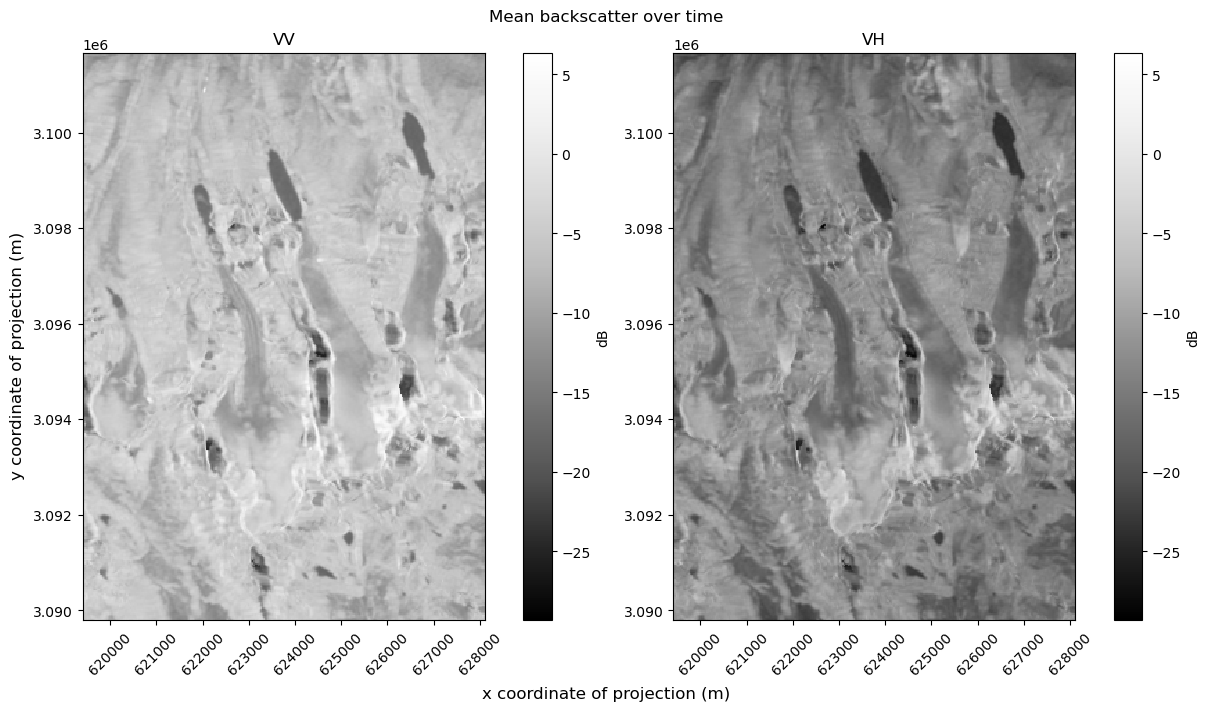

In [40]:
global_min = np.array([
    s1_tools.power_to_db(clipped_cube['vv'].mean(dim='acq_date')).min(),
    s1_tools.power_to_db(clipped_cube['vh'].mean(dim='acq_date')).min(),
]).min()

global_max = np.array([
    s1_tools.power_to_db(clipped_cube['vv'].mean(dim='acq_date')).max(),
    s1_tools.power_to_db(clipped_cube['vh'].mean(dim='acq_date')).max()
]).max()

fig, ax = plt.subplots(ncols=2, figsize=(12,7),layout='constrained')

s1_tools.power_to_db(clipped_cube['vv'].mean(dim='acq_date')).plot(ax=ax[0],
                                                                   cmap=plt.cm.Greys_r, 
                                                                   vmin=global_min,
                                                                   vmax=global_max,
                                                                   cbar_kwargs=({'label':'dB'}))
s1_tools.power_to_db(clipped_cube['vh'].mean(dim='acq_date')).plot(ax=ax[1],
                                                                   cmap=plt.cm.Greys_r,
                                                                   vmin=global_min,
                                                                   vmax=global_max,
                                                                   cbar_kwargs=({'label':'dB'}))

for i in range(len(ax)):
    ax[i].set_ylabel(None)
    ax[i].set_xlabel(None)
    ax[i].tick_params(axis="x", labelrotation=45)
fig.suptitle('Mean backscatter over time')
ax[0].set_title('VV')
ax[1].set_title('VH')
fig.supylabel('y coordinate of projection (m)')
fig.supxlabel('x coordinate of projection (m)');

#### Expand dimensions


We could convert the VV and VH data from being represented as data variables to as elements of a band dimension. This would let us use Xarray's FacetGrid plotting that creates small multiples along a given dimension.

In [41]:
clipped_cube_da = clipped_cube.to_array(dim='band')

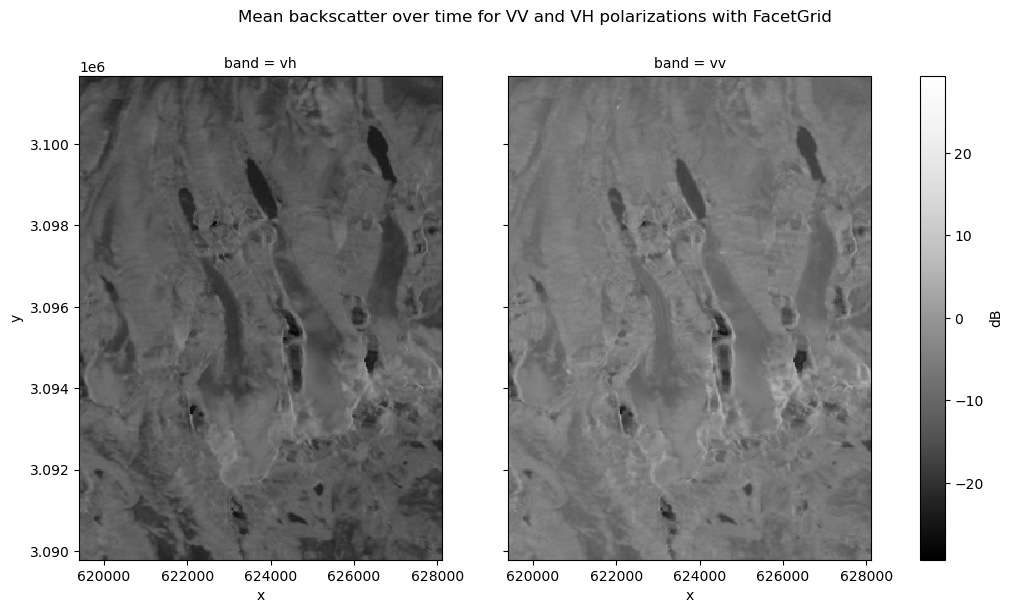

In [42]:

f = s1_tools.power_to_db(clipped_cube_da.mean(dim='acq_date')).plot(col='band',
                                                                cmap=plt.cm.Greys_r, 
                                                                cbar_kwargs=({'label':'dB'}))

f.fig.suptitle('Mean backscatter over time for VV and VH polarizations with FacetGrid')
f.fig.set_figheight(7)
f.fig.set_figwidth(12);


The area that we're looking at is in the mountainous region on the border between the Sikkim region of India and China. There are four north-facing glacier visible in the image, each with a lake at the toe. Bodies of water like lakes tend to appear dark in C-band SAR images because water is smooth with respect to the wavelength of the signal, meaning that most of the emitted signal is scattered away from the sensor. where surfaces that are rough at the scale of C-band wavelength, more signal is returned to the sensor and the backscatter image is brighter. For much more detail on interpreting SAR imagery, see the resources linked in the Sentinel-1 section of the [tutorial data](../../background/tutorial_data.md) page.

### {{e2_s1_nb3}}

Now let's look at how backscatter may vary seasonally for a single polarization (for more on time-related GroupBy operations see the [Xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)). This is an example of a 'split-apply-combine' operation, where a dataset is split into groups (in this case, time steps are split into seasons), an operation is applied (in this case, the mean is calculated) and then the groups are combined into a new object.

In [43]:
clipped_cube_gb = clipped_cube.groupby("acq_date.season").mean()

The temporal dimension of the new object has an element for each season rather than an element for each time step.

In [44]:
clipped_cube_gb

<xarray.Dataset> Size: 4MB
Dimensions:      (season: 4, y: 396, x: 290)
Coordinates:
  * x            (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 8B 0
  * season       (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    vh           (season, y, x) float32 2MB 0.02098 0.0221 ... 0.04669 0.04661
    vv           (season, y, x) float32 2MB 0.1108 0.1239 ... 0.2862 0.2956
Attributes: (12/13)
    unmasked_or_watermasked:           u
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    sensor:                            S1A
    ...                                ...
    processing_software:               G
    terrain_correction_pixel_spacing:  RTC30
    orbit_type:                        P
    output_type:                       g
    output_unit:                       p
    primary_polarization:              V

In [45]:
# order seasons correctly
clipped_cube_gb = clipped_cube_gb.reindex({"season": ["DJF", "MAM", "JJA", "SON"]})
clipped_cube_gb

<xarray.Dataset> Size: 4MB
Dimensions:      (x: 290, y: 396, season: 4)
Coordinates:
  * x            (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * season       (season) <U3 48B 'DJF' 'MAM' 'JJA' 'SON'
    spatial_ref  int64 8B 0
Data variables:
    vh           (season, y, x) float32 2MB 0.02098 0.0221 ... 0.04669 0.04661
    vv           (season, y, x) float32 2MB 0.1108 0.1239 ... 0.2862 0.2956
Attributes: (12/13)
    unmasked_or_watermasked:           u
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    sensor:                            S1A
    ...                                ...
    processing_software:               G
    terrain_correction_pixel_spacing:  RTC30
    orbit_type:                        P
    output_type:                       g
    output_unit:                       p
    primary_polarization:              V

Visualize mean backscatter in each season:

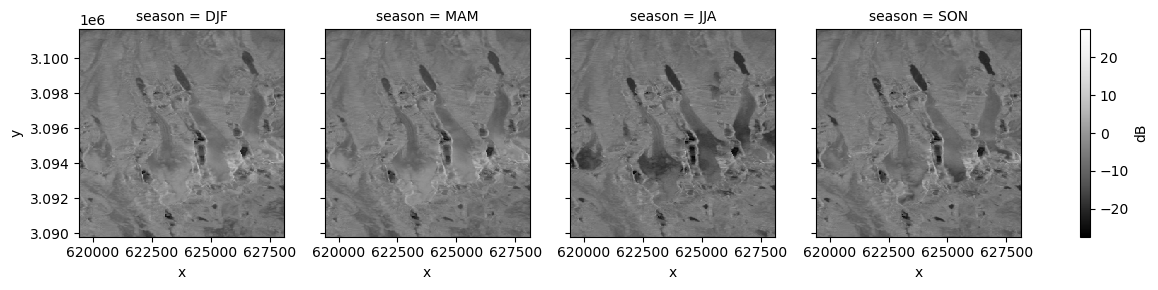

In [46]:
fg_vv = s1_tools.power_to_db(clipped_cube_gb.vv).plot(col="season", cmap=plt.cm.Greys_r,
                                                       cbar_kwargs=({'label':'dB'}));

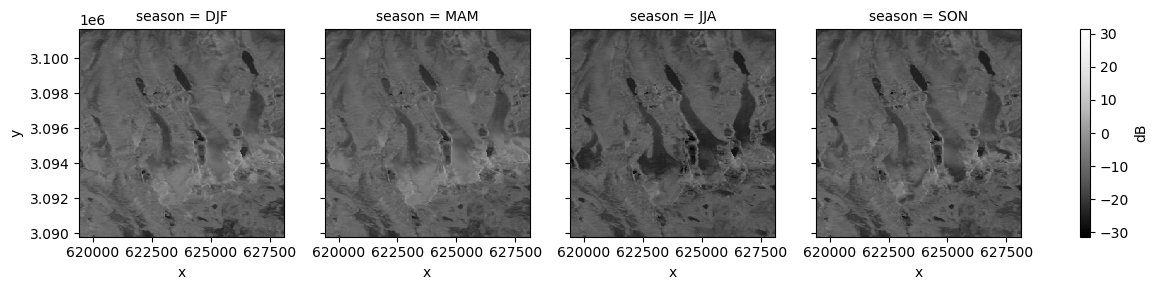

In [47]:
fg_vh = s1_tools.power_to_db(clipped_cube_gb.vh).plot(col='season',
                                                      cmap=plt.cm.Greys_r,
                                                      cbar_kwargs=({'label':'dB'}))

The glacier surfaces appear much darker during the summer months than other seasons, especially in the lower reaches of the glaciers. Like the lake surfaces above, this suggests largely specular reflection where no signal returns in the incident direction. It could be that during the summer months, enough liquid water is present at the glacier surface to produce this scattering. 

### {{e3_s1_nb3}}

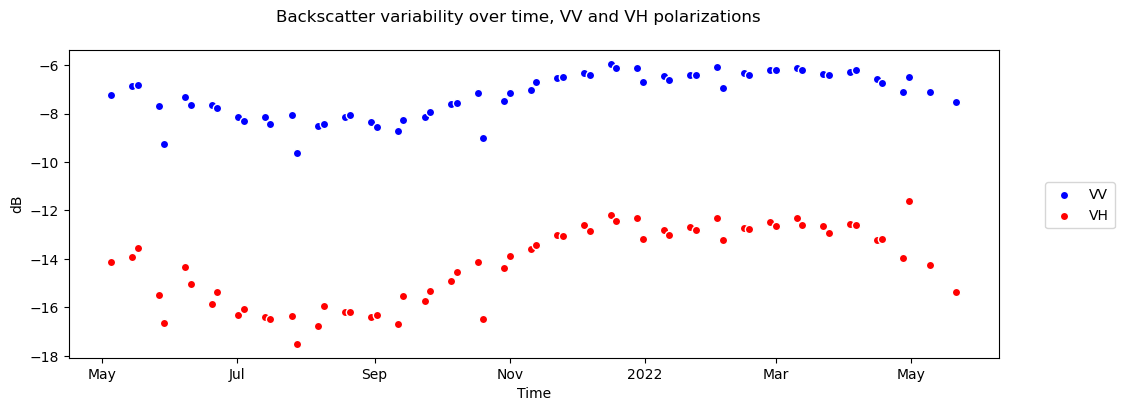

In [48]:
fig, ax = plt.subplots(figsize=(12,4))

s1_tools.power_to_db(clipped_cube['vv'].median(dim=['x','y'])).plot.scatter(ax=ax, label='VV', c='b')
s1_tools.power_to_db(clipped_cube['vh'].median(dim=['x','y'])).plot.scatter(ax=ax, label='VH', c='r')
fig.legend(loc='center right')

fig.suptitle('Backscatter variability over time, VV and VH polarizations')
ax.set_title(None)
ax.set_ylabel('dB')
ax.set_xlabel('Time');

To take a look at backscatter variability in more detail, you could use [`hvplot`](https://tutorial.xarray.dev/intermediate/hvplot.html) to make an interactive plot:

In [49]:
vv_plot = s1_tools.power_to_db(clipped_cube['vv'].mean(dim=['x','y'])).hvplot.scatter(x='acq_date')
vh_plot = s1_tools.power_to_db(clipped_cube['vh'].mean(dim=['x','y'])).hvplot.scatter(x='acq_date')

vv_plot * vh_plot

:Overlay
   .Scatter.I  :Scatter   [acq_date]   (vv)
   .Scatter.II :Scatter   [acq_date]   (vh)

{{conclusion}}

In this notebook, we demonstrated how to use the data cube that we assembled in the previous notebooks. We saw various ways that having metadata accessible and attached to the correct dimensions of the data cube made learning about teh dataset much smoother and more efficient than it would otherwise be. 

In the next notebook, we'll work with a different Sentinel-1 RTC dataset. We'll write this dataset to disk in order to use it in the final notebook of the tutorial, a comparison of two datasets. 

In [50]:
clipped_cube.to_zarr(f"../data/{timeseries_type}_timeseries/intermediate_cubes/s1_asf_clipped_cube.zarr", mode="w")